# Imports

In [13]:
import pandas as pd
import numpy as np

# Base
from collections import Counter
import re

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

from tqdm import tqdm
tqdm.pandas()

nlp = spacy.load("en_core_web_lg")

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [ ]:
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

In [21]:

from tqdm import tqdm
tqdm.pandas()

# Preview Data

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/JenBanks8585/WhiskeyDS20/main/data/Corona_NLP_train.csv' ,encoding='latin1')

In [9]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
    df['OriginalTweet'][1]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

# Tokenizing

### Custom Tokenizer

In [19]:
def tokenize(text):

    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [20]:
df['custome_token'] = df['OriginalTweet'].progress_apply(tokenize)

100%|█████████████████████████████████████████████████████████████████████████| 41157/41157 [00:01<00:00, 33004.81it/s]


In [23]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,custome_token
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa..."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, to, your, neighbours, family, t..."


### Spacy Tokenizer

In [25]:
nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [32]:
tokens = []
for doc in  tokenizer.pipe(df['OriginalTweet'], batch_size = 500):
    doc_token = [token.text for token in doc]
    tokens.append(doc_token)
    
df['spacy_tokens'] = tokens
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,custome_token,spacy_tokens
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[@MeNyrbie, @Phil_Gahan, @Chrisitv, https://t...."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, to, your, neighbours, family, t...","[advice, Talk, to, your, neighbours, family, t..."


### PorterStemmer

In [35]:
porterstem= PorterStemmer()

def porterize(text):
    porter_tokens= []
    for word in text:
        tokens = porterstem.stem(word)
        porter_tokens.append(tokens)
        return porter_tokens   

In [42]:
df['porter_tokens'] = df['spacy_tokens'].progress_apply(porterize)

100%|█████████████████████████████████████████████████████████████████████████| 41157/41157 [00:01<00:00, 25595.10it/s]


In [43]:
df['porter_tokens']

0          [@menyrbi]
1             [advic]
2        [coronaviru]
3                [My]
4               [me,]
             ...     
41152        [airlin]
41153       [respons]
41154           [you]
41155            [Is]
41156    [@tartiicat]
Name: porter_tokens, Length: 41157, dtype: object

### Lemmatization

In [24]:
# Define a function that will get the lemmas
nlp = spacy.load("en_core_web_lg")

def get_lemmas(text):
    
    lemmas =[]
    doc = nlp(text)
    
    for token in doc:
        if ((token.is_stop ==False) and (token.is_punct ==False) and (token.pos_ != 'PRON')):
            lemmas.append(token.lemma_)
    
    return lemmas

In [40]:
df['lemmas'] = df['OriginalTweet'].progress_apply(get_lemmas)

100%|████████████████████████████████████████████████████████████████████████████| 41157/41157 [14:09<00:00, 48.42it/s]


In [41]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,custome_token,spacy_tokens,porter_tokens,lemmas
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[@MeNyrbie, @Phil_Gahan, @Chrisitv, https://t....",[@],"[@MeNyrbie, @Phil_Gahan, @chrisitv, https://t...."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, to, your, neighbours, family, t...","[advice, Talk, to, your, neighbours, family, t...",[a],"[advice, talk, neighbours, family, exchange, p..."


In [66]:
df['data'] = [" ".join(df['spacy_tokens'][i]) for i in range(df.shape[0])]

# Vectorization

### CountVectorizer

In [73]:
cvectorizer = CountVectorizer(stop_words = 'english', max_features = 1000)

# 'data' should be the column of lists of documents
dat = list(df['data'])
cvectorizer.fit(dat)

dtm_cvectorizer = cvectorizer.transform(dat)

In [74]:
# column names
cols = cvectorizer.get_feature_names()
data = dtm_cvectorizer.todense()

dtm = pd.DataFrame(data = data, columns = cols)
dtm.tail()

,000,10,100,11,12,14,15,16,18,19,...,worst,worth,wrong,year,years,yes,yesterday,york,youtube,youâ
41152,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
41153,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
41154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41155,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
41156,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

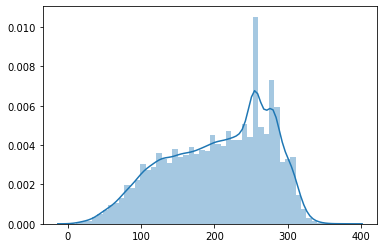

In [75]:
doc_len = [len(doc) for doc in dat]
sns.distplot(doc_len)

### TfidfVectorizer

In [76]:

# Apply TFIDF Vectorizer to our Data

from sklearn.feature_extraction.text import TfidfVectorizer

#Instantiate vectorizer object
tfidf= TfidfVectorizer(stop_words='english', max_features=5000)

#Create a vocabulaey and get word counts per document
#SImila to fit_prdict
dtm_tfidf= tfidf.fit_transform(dat)

# Get feature names for DF column headers
dtm_tfidf= pd.DataFrame(dtm_tfidf.todense(), columns = tfidf.get_feature_names())

#View Feature Matrix as Dataframe
dtm_tfidf.head()

,00,000,00pm,03,08,09,10,100,1000,10am,...,yoy,yr,yâ,zealand,zero,zimbabwe,zombie,zombies,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cosine Simalarity

#### Nearest Neighbors

In [78]:

from sklearn.neighbors import NearestNeighbors

# Instantiate
nn = NearestNeighbors(n_neighbors = 8, algorithm = 'kd_tree')

#Fit on dtm
nn.fit(dtm_tfidf)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                 radius=1.0)

In [83]:
sample = dtm_tfidf.iloc[3].values

In [80]:
df['data'].iloc[3]

"My food stock is not the only one which is empty... \r\r\n\r\r\n PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\n Stay calm, stay safe. \r\r\n\r\r\n #COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"

In [85]:
nn.kneighbors([sample])

(array([[0.        , 0.98168338, 0.98837986, 1.        , 1.        ,
         1.        , 1.        , 1.        ]]),
 array([[    3,  3240, 12716, 28549, 17710, 26640, 13777,   186]],
       dtype=int64))

In [86]:
df['data'].iloc[3240]

'Stay Safe .. Keep Motoring On https://t.co/MAwzC7BJS7'

In [87]:
df['data'].iloc[12716]

'Stay safe everyone'

In [88]:
df['data'].iloc[26640]

'Shankar stranded in Evicted from accommodation No No due to When will be rescued from'

# Classification

In [90]:
df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [93]:
conversion_dict = {'Positive':2, 'Negative':0, 'Neutral':1, 'Extremely Positive':2, 'Extremely Negative':0}
df['Sentiment'] = df['Sentiment'].replace(conversion_dict)
df['Sentiment']

0        1
1        2
2        2
3        2
4        0
        ..
41152    1
41153    0
41154    2
41155    1
41156    0
Name: Sentiment, Length: 41157, dtype: int64

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'],
                                                   df['Sentiment'],
                                                   test_size = 0.2,
                                                   stratify = df['Sentiment'],
                                                   random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32925,) (8232,) (32925,) (8232,)


In [95]:
### Pipeline with Tfidf

In [103]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2))
                       
rfc = RandomForestClassifier()

# Define the Pipeline
pipe = Pipeline([
                 #Vectorizer
                 ('vect', vect),
                 # Classifier
                 ('clf', rfc)
                ])

In [104]:
# Hyper parameters

parameters = {
    'vect__max_df': ( 0.75, 1.0),  
    'clf__n_estimators':(100, 500)    
}

# Instantiate gridsearch, fit on training data
grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 319.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [ ]:

# Computing for best score
print(grid_search.best_score_)

# Checking best parameters
print(grid_search.best_params_)

In [ ]:
# Predictions on test sample
pred = grid_search.predict(X_test)
pred[:5]

In [ ]:
# Topic Modelling